In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase, JLD

### Approximate SyncRank with sparsified Laplacian 


MUN graph model

In [2]:
type = "MUN" 

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.9
eta = 0.2

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# print least eigenvalues
B = magnetic_incidence(meta_g)
l = eigvals(B' * B)
println("least eigenvalue: ", l[1:3])

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng)

# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

# saving results
save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

least eigenvalue: 

UndefVarError: UndefVarError: D_all not defined

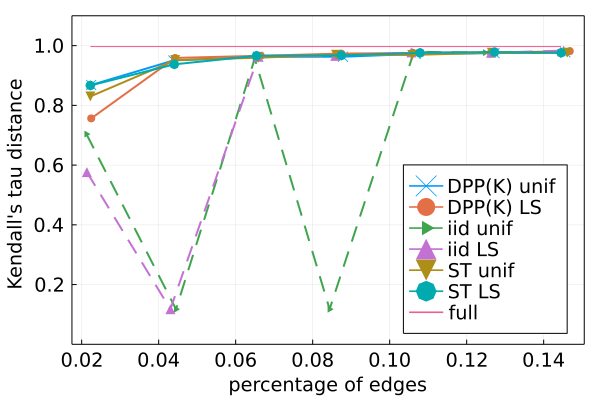

In [8]:
# plotting Kendall's tau distance between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_all,y_limits;legendposition)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

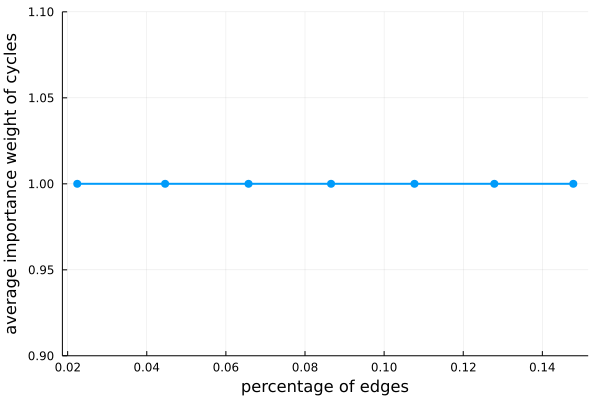

In [13]:
# plotting average importance weight of cycles
metric = "weight"
metric_std = metric * "_std"

method = "DPP(K) LS"
D = D_results[method]
x = D["percent_edges"]
y = D[metric]
y_er = D[metric_std]
y_limits = (0.9, 1.1)

plt = plot(
    x,
    y;
    yerror=y_er,
    markerstrokecolor=:auto,
    markershape=:circle,
    markersize=5,
    linewidth=2,
    markerstrokewidth=2,
    legend = false
)
xlabel!("percentage of edges")
ylabel!("average importance weight of cycles")

ylims!(y_limits)

display(plt)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

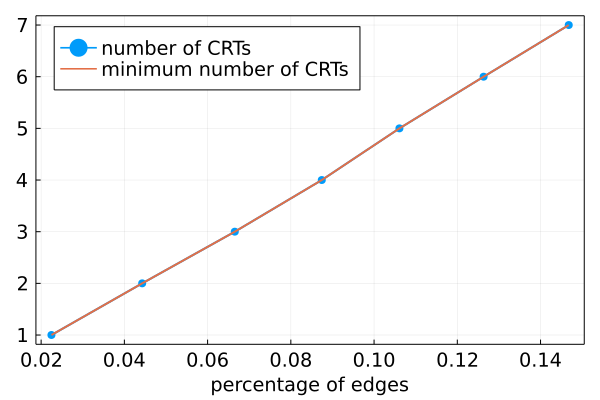

In [10]:
# plotting number of cycle rooted trees wrt number of batches

method = "DPP(K) LS"
legendposition=:topleft
plot_nb_cycles(D_all,method;legendposition)

metric = "number_CRTs"
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")


 ERO graph model

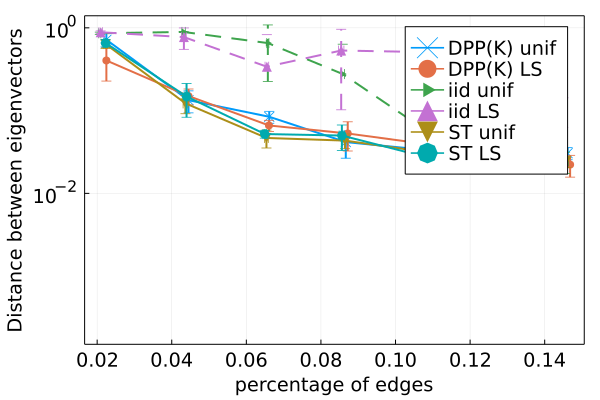

least eigenvalue: [17.01717364001493, 76.35378055233515, 77.3690068785359]


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [23]:
type = "ERO" 

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.9
eta = 0.2

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 3 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# print least eigenvalues
B = magnetic_incidence(meta_g)
l = eigvals(B' * B)
println("least eigenvalue: ", l[1:3])

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng)

# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

# saving results
save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

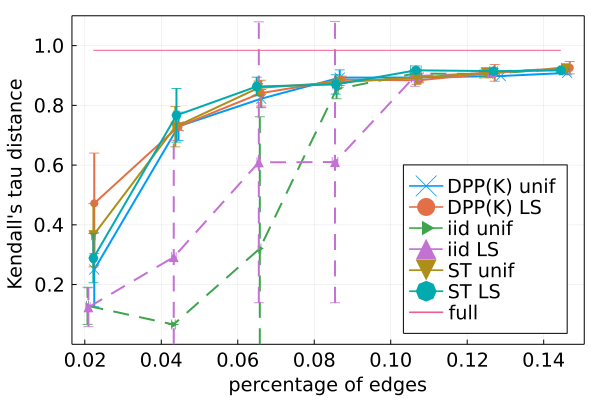

In [24]:
# plotting Kendall's tau distance between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

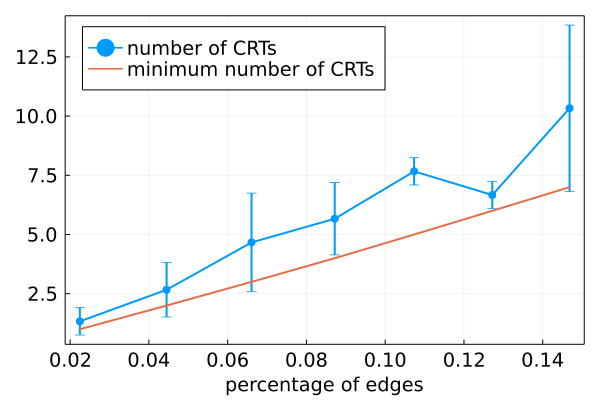

In [25]:
# plotting number of cycle rooted trees wrt number of batches

method = "DPP(K) LS"
legendposition=:topleft
plot_nb_cycles(D_results,method;legendposition)

metric = "number_CRTs"
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

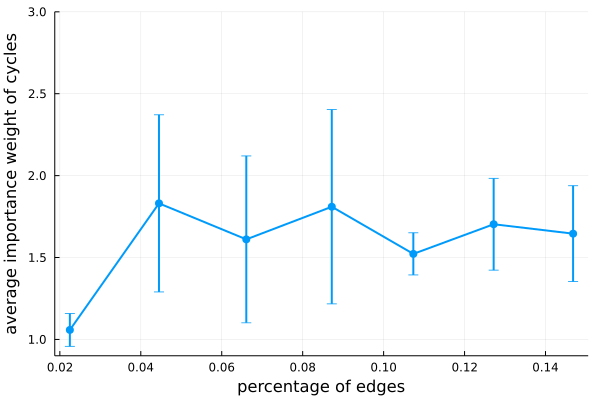

In [26]:
# plotting average importance weight of cycles
metric = "weight"
metric_std = metric * "_std"

method = "DPP(K) LS"
D = D_results[method]
x = D["percent_edges"]
y = D[metric]
y_er = D[metric_std]
y_limits = (0.9, 3)

plt = plot(
    x,
    y;
    yerror=y_er,
    markerstrokecolor=:auto,
    markershape=:circle,
    markersize=5,
    linewidth=2,
    markerstrokewidth=2,
    legend = false
)
xlabel!("percentage of edges")
ylabel!("average importance weight of cycles")

ylims!(y_limits)

display(plt)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")